<a href="https://colab.research.google.com/github/colin-hehir/Forecasting-of-CO2-Emissions/blob/main/Predictions/India_Predicted_CO2_Emissions_in_2030.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
import pandas as pd
from pandas import DataFrame, Series
downloaded = drive.CreateFile({'id':'19nsnfdS5KJxyEcn489q4Svg6AKULo-t9'}) 
downloaded.GetContentFile('India_CO2_Emissions.csv')  
co2_forecast_data = pd.read_csv('India_CO2_Emissions.csv')
print(co2_forecast_data.describe())

               co2
count   152.000000
mean    358.003250
std     624.664145
min       0.395000
25%      21.243500
50%      53.100000
75%     332.395500
max    2625.968000


In [ ]:
!pip install darts
!pip install u8darts[all]
!pip install u8darts[fbprophet]
!pip install u8darts[prophet]
!pip install prophet
!pip install fbprophet
!pip install u8darts[pmdarima]
!pip install u8darts[torch]

     |████████████████████████████████| 359 kB 5.3 MB/s 
     |████████████████████████████████| 9.8 MB 32.5 MB/s 
     |████████████████████████████████| 582 kB 6.9 MB/s 
     |████████████████████████████████| 172 kB 7.0 MB/s 
     |████████████████████████████████| 65 kB 1.6 MB/s 
     |████████████████████████████████| 43 kB 1.4 MB/s 
     |████████████████████████████████| 1.4 MB 22.7 MB/s 
     |████████████████████████████████| 793 kB 26.2 MB/s 
     |████████████████████████████████| 11.2 MB 30.3 MB/s 
     |████████████████████████████████| 381 kB 53.4 MB/s 
     |████████████████████████████████| 899 kB 41.8 MB/s 
     |████████████████████████████████| 49 kB 3.3 MB/s 
     |████████████████████████████████| 45 kB 1.4 MB/s 
     |████████████████████████████████| 398 kB 36.3 MB/s 
     |████████████████████████████████| 596 kB 46.4 MB/s 
     |████████████████████████████████| 136 kB 56.9 MB/s 
     |████████████████████████████████| 1.1 MB 41.1 MB/s 
     |██████████████████

     |████████████████████████████████| 359 kB 5.1 MB/s 
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.68
    Uninstalling cmdstanpy-0.9.68:
      Successfully uninstalled cmdstanpy-0.9.68
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
prophet 1.0.1 requires cmdstanpy==0.9.68, but you have cmdstanpy 0.9.5 which is incompatible.


In [ ]:
from darts import TimeSeries

In [ ]:
series = TimeSeries.from_dataframe(co2_forecast_data, 'year', 'co2')

In [ ]:
s = series.pd_series()
s.replace(0.0, np.nan, inplace=True)
s = s.fillna(method="bfill")
series = series.from_series(s)

In [ ]:
series

<TimeSeries (DataArray) (year: 163, component: 1, sample: 1)>
array([[[3.950000e-01]],

       [[6.370000e-01]],

       [[6.440000e-01]],

       [[4.980000e-01]],

       [[5.510000e-01]],

       [[6.110000e-01]],

       [[5.780000e-01]],

       [[5.680000e-01]],

       [[6.410000e-01]],

       [[1.769000e+00]],

...

       [[1.780130e+03]],

       [[1.963586e+03]],

       [[2.036937e+03]],

       [[2.185856e+03]],

       [[2.268567e+03]],

       [[2.382223e+03]],

       [[2.433856e+03]],

       [[2.599806e+03]],

       [[2.625968e+03]],

       [[2.441792e+03]]])
Coordinates:
  * year       (year) datetime64[ns] 1858-01-01 1859-01-01 ... 2020-01-01
  * component  (component) <U1 '0'
Dimensions without coordinates: sample

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import shutil
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook as tqdm
from pandas import Timestamp

from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
import math as m


from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, ExponentialSmoothing, BlockRNNModel
from darts.metrics import mape, mse, mae, r2_score
from darts.utils.statistics import check_seasonality, plot_acf
from darts.utils.timeseries_generation import datetime_attribute_timeseries

import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

In [ ]:
train, val = series.split_after(pd.Timestamp("19900101"))

# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

# create year covariate series
year_series = datetime_attribute_timeseries(
    pd.date_range(start=series.start_time(), freq=series.freq_str, end=series.end_time()),
    attribute="year",
    one_hot=False,
)
year_series = Scaler().fit_transform(year_series)
covariates = year_series
cov_train, cov_val = covariates.split_after(pd.Timestamp("19900101"))

In [ ]:
import time
t_start1 = time.perf_counter()


%matplotlib inline

## Importing Libraries
import sys
import numbers
import time
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from functools import reduce

import pmdarima as pmd
import statsmodels.api as sm 
from scipy.stats import normaltest

from darts import TimeSeries
from darts.models import (
    NaiveSeasonal,
    NaiveDrift,
    Prophet,
    ExponentialSmoothing,
    ARIMA,
    AutoARIMA,
    Theta,
    RegressionEnsembleModel
)
from darts.metrics import mape, mase, mae, mse, ope, r2_score, rmse, rmsle
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis
from darts.dataprocessing.transformers.boxcox import BoxCox
from darts.utils.utils import ModelMode  

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

TRACE = False  
MSEAS = 12                    # seasonality default
ALPHA = 0.05                  # significance level default

In [ ]:
!pip install matplotlib==3.1.1
import matplotlib.pyplot as plt

     |████████████████████████████████| 13.1 MB 4.4 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.1
    Uninstalling matplotlib-3.5.1:
      Successfully uninstalled matplotlib-3.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
u8darts 0.18.0 requires matplotlib>=3.3.0, but you have matplotlib 3.1.1 which is incompatible.
prophet 1.0.1 requires cmdstanpy==0.9.68, but you have cmdstanpy 0.9.5 which is incompatible.
nfoursid 1.0.0 requires matplotlib>=3.3, but you have matplotlib 3.1.1 which is incompatible.
darts 0.18.0 requires matplotlib>=3.3.0, but you have matplotlib 3.1.1 which is incompatible.
arviz 0.11.4 requires typing-extensions<4,>=3.7.4.3, but you have typing-extensions 4.1.1 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


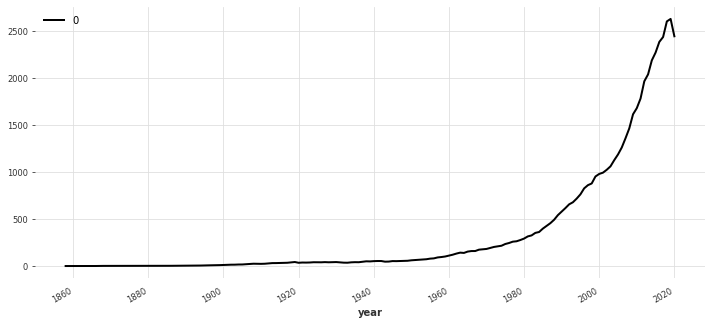

In [ ]:
plt.figure(100, figsize=(12, 5))
series.plot()

In [ ]:
# prepare Exponential Smoothing forecaster

m_expon = ExponentialSmoothing(seasonal=None)

In [ ]:
model = m_expon
res2030 = model.fit(series_transformed)
forecast2030 = model.predict(10)

In [ ]:
forecast2030 

<TimeSeries (DataArray) (year: 10, component: 1, sample: 1)>
array([[[4.14353843]],

       [[4.06410528]],

       [[3.98467213]],

       [[3.90523897]],

       [[3.82580582]],

       [[3.74637266]],

       [[3.66693951]],

       [[3.58750636]],

       [[3.5080732 ]],

       [[3.42864005]]])
Coordinates:
  * year       (year) datetime64[ns] 2021-01-01 2022-01-01 ... 2030-01-01
  * component  (component) object '0'
Dimensions without coordinates: sample

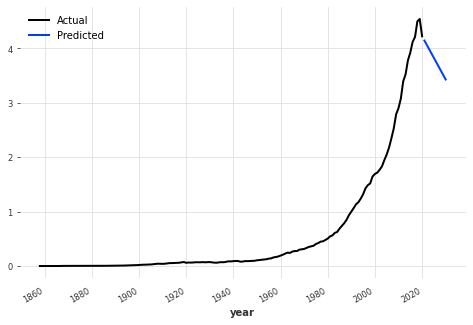

In [ ]:
plt.figure(figsize=(8, 5))
series_transformed.plot(label="Actual")
forecast2030.plot(label="Predicted")

In [ ]:
series_untransformed = transformer.inverse_transform(series_transformed)
forecast2030_untransformed = transformer.inverse_transform(forecast2030)

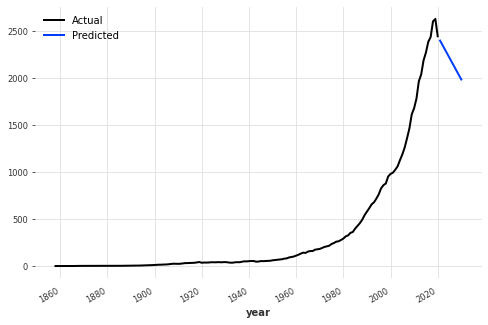

In [ ]:
plt.figure(figsize=(8, 5))
series_untransformed.plot(label="Actual")
forecast2030_untransformed.plot(label="Predicted")

In [ ]:
forecast2030_untransformed

<TimeSeries (DataArray) (year: 10, component: 1, sample: 1)>
array([[[2395.86987047]],

       [[2349.94773704]],

       [[2304.02560362]],

       [[2258.1034702 ]],

       [[2212.18133678]],

       [[2166.25920336]],

       [[2120.33706994]],

       [[2074.41493651]],

       [[2028.49280309]],

       [[1982.57066967]]])
Coordinates:
  * year       (year) datetime64[ns] 2021-01-01 2022-01-01 ... 2030-01-01
  * component  (component) object '0'
Dimensions without coordinates: sample

**Predicted CO2 Emissions in 2030 from India:** 1982.57066967

**CO2 Emissions in 1990 from India:** 578.518

**Target CO2 Emissions in 2030 from India (Cut at least by 55% compared with 1990 levels):** 260.3331

**Target met for India:** No


